In [1]:
import numpy as np 
import pandas as pd 
import cv2
import os
from zipfile import ZipFile
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras_preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential

In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
IMAGE_SIZE = 224

In [3]:
def info_image(im):
    # Compute the center (cx, cy) and radius of the eye
    cy = im.shape[0]//2
    midline = im[cy,:]
    midline = np.where(midline>midline.mean()/3)[0]
    if len(midline)>im.shape[1]//2:
        x_start, x_end = np.min(midline), np.max(midline)
    else: # This actually rarely happens p~1/10000
        x_start, x_end = im.shape[1]//10, 9*im.shape[1]//10
    cx = (x_start + x_end)/2
    r = (x_end - x_start)/2
    return cx, cy, r

def resize_image(im, augmentation=True):
    # Crops, resizes and potentially augments the image to IMAGE_SIZE
    cx, cy, r = info_image(im)
    scaling = IMAGE_SIZE/(2*r)
    rotation = 0
    if augmentation:
        scaling *= 1 + 0.3 * (np.random.rand()-0.5)
        rotation = 360 * np.random.rand()
    M = cv2.getRotationMatrix2D((cx,cy), rotation, scaling)
    M[0,2] -= cx - IMAGE_SIZE/2
    M[1,2] -= cy - IMAGE_SIZE/2
    return cv2.warpAffine(im,M,(IMAGE_SIZE,IMAGE_SIZE)) # This is the most important line

def subtract_median_bg_image(im):
    k = np.max(im.shape)//20*2+1
    bg = cv2.medianBlur(im, k)
    return cv2.addWeighted (im, 4, bg, -4, 128)

def subtract_gaussian_bg_image(im):
    k = np.max(im.shape)/10
    bg = cv2.GaussianBlur(im ,(0,0) ,k)
    return cv2.addWeighted (im, 4, bg, -4, 128)

def id_to_image(id_code, resize=True, augmentation=False, subtract_gaussian=False, subtract_median=False):
    path = 'C:/Users/maste/Desktop/DIR/train_images/{}.png'.format(id_code)
    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    if resize_image:
        im = resize_image(im, augmentation)
    if subtract_gaussian:
        im = subtract_gaussian_bg_image(im)
    if subtract_median:
        im = subtract_median_bg_image(im)
    return im

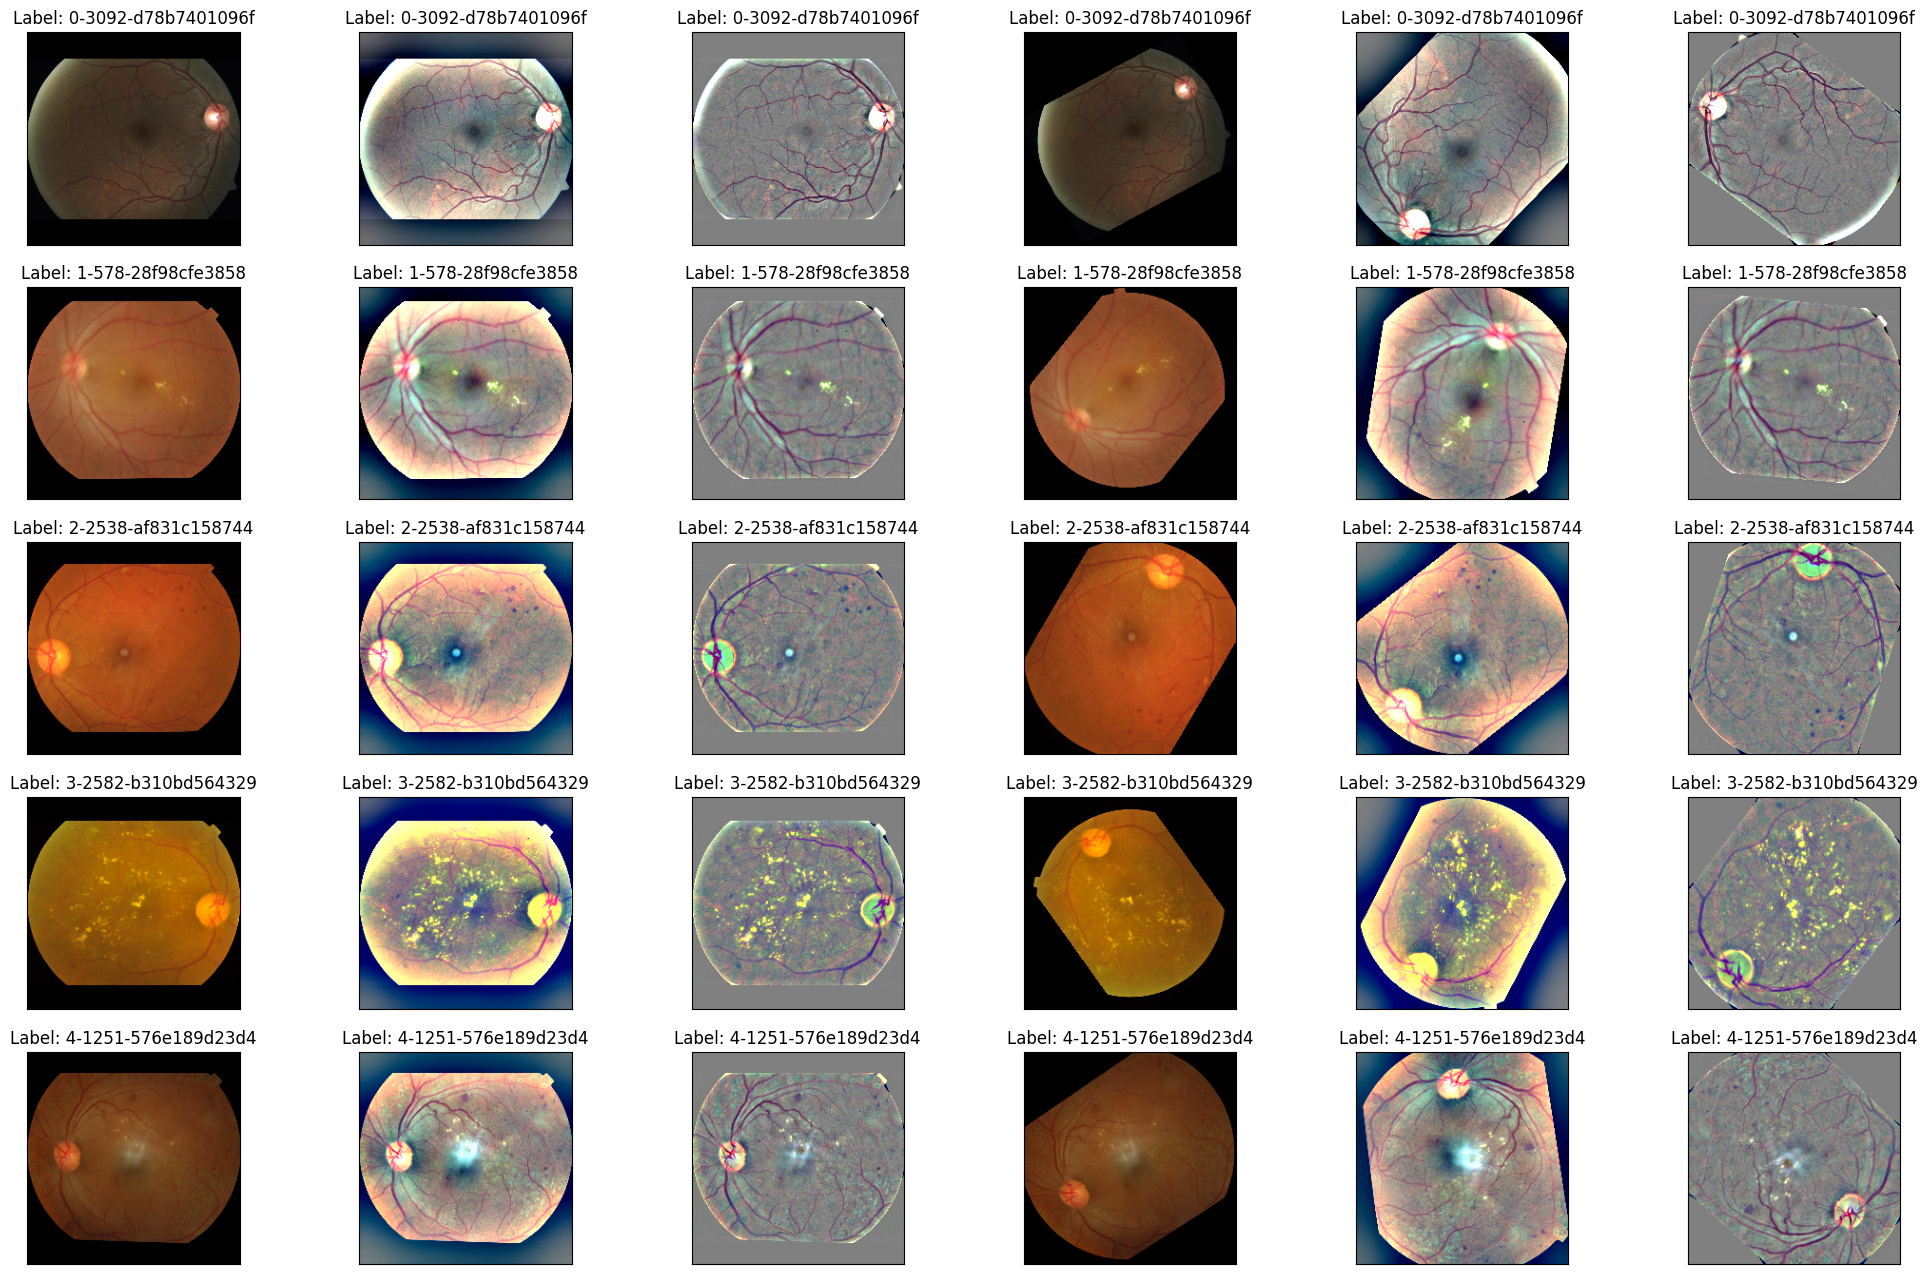

In [4]:
df_train = pd.read_csv('C:/Users/maste/Desktop/DIR/train.csv')
fig = plt.figure(figsize=(25, 16))
SEED = np.random.randint(0,100)

def plot_col(col, id2im, n_cols=6):
    for class_id in range(0,5):
        for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(1, random_state=SEED).iterrows()):
            ax = fig.add_subplot(5, n_cols, class_id * n_cols + i + col, xticks=[], yticks=[])
            im = id2im(row['id_code'])
            plt.imshow(im)
            ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

# display normal image of each class
plot_col(1, lambda x: id_to_image(x))

# display normal image of each class
plot_col(4, lambda x: id_to_image(x, augmentation=True))

# display normal image of each class
plot_col(2, lambda x: id_to_image(x, subtract_gaussian=True))

# display normal image of each class
plot_col(5, lambda x: id_to_image(x, subtract_gaussian=True, augmentation=True))

# display normal image of each class
plot_col(3, lambda x: id_to_image(x, subtract_median=True))

# display normal image of each class
plot_col(6, lambda x: id_to_image(x, subtract_median=True, augmentation=True))

In [4]:
dataset = []
labels = []

In [7]:
def prepare_Images(label,path):
    img=cv2.imread(path,cv2.IMREAD_COLOR)
    img_res=cv2.resize(img,(128,128))
    img_array = img_to_array(img_res)
    img_array = img_array/255.0
    dataset.append(img_array)
    labels.append(str(label))

In [8]:
train_Data = pd.read_csv("C:/Users/maste/Desktop/DIR/train.csv")
train_Data.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [9]:
id_code_Data = train_Data['id_code']
diagnosis_Data = train_Data['diagnosis']

In [10]:
for id_code,diagnosis in tqdm(zip(id_code_Data,diagnosis_Data)):
    path = os.path.join('C:/Users/maste/Desktop/DIR/train_images','{}.png'.format(id_code))
    prepare_Images(diagnosis,path)

3662it [04:20, 14.07it/s]


In [11]:
images = np.array(dataset)
label_arr = np.array(labels)

In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(images,label_arr,stratify=label_arr,test_size=0.20,random_state=44)

In [13]:
x_train.shape

(2929, 128, 128, 3)

In [14]:
x_test.shape

(733, 128, 128, 3)

In [15]:
y_train.shape

(2929,)

In [16]:
y_test.shape

(733,)

In [17]:
y_train= np_utils.to_categorical(y_train, num_classes=5)
y_test = np_utils.to_categorical(y_test, num_classes=5)

In [18]:
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(5,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [19]:
from tensorflow.keras.layers import Conv2D, Dense, Conv2DTranspose, MaxPooling2D, Concatenate
from tensorflow.keras import Input, Model
def create_U_Net(input_shape=(256,256,3)):
    inputs = Input(shape=input_shape)
    
    # Downward part
    x1 = Conv2D(filters= 64, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(inputs)
    x1 = Conv2D(filters= 64, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(x1)
    
    # Downward part
    x2 = MaxPooling2D(pool_size=(2, 2), strides=2)(x1)
    x2 = Conv2D(filters= 128, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(x2)
    x2 = Conv2D(filters= 128, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(x2)
    
    # Downward part
    x3 = MaxPooling2D(pool_size=(2, 2), strides=2)(x2)
    x3 = Conv2D(filters= 256, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(x3)
    x3 = Conv2D(filters= 256, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(x3)
    
    # Downward part
    x4 = MaxPooling2D(pool_size=(2, 2), strides=2)(x3)
    x4 = Conv2D(filters= 512, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(x4)
    x4 = Conv2D(filters= 512, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(x4)
    
    # Downward part
    x5 = MaxPooling2D(pool_size=(2, 2), strides=2)(x4)
    x5 = Conv2D(filters= 1024, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(x5)
    x5 = Conv2D(filters= 1024, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(x5)
    
    # Upward part
    x6 = Conv2DTranspose(filters=512, kernel_size = (3,3), strides=(2,2), padding="same", activation="relu")(x5)
    x6 = Concatenate(axis=3)([x4, x6])
    x6 = Conv2D(filters=512, kernel_size = (3,3), strides=1, padding="same", activation="relu")(x6)
    x6 = Conv2D(filters=512, kernel_size = (3,3), strides=1, padding="same", activation="relu")(x6)
    
    # Upward part
    x7 = Conv2DTranspose(filters=256, kernel_size = (3,3), strides=(2,2), padding="same", activation="relu")(x6)
    x7 = Concatenate(axis=3)([x3, x7])
    x7 = Conv2D(filters=256, kernel_size = (3,3), strides=1, padding="same", activation="relu")(x7)
    x7 = Conv2D(filters=256, kernel_size = (3,3), strides=1, padding="same", activation="relu")(x7)
    
    # Upward part
    x8 = Conv2DTranspose(filters=128, kernel_size = (3,3), strides=(2,2), padding="same", activation="relu")(x7)
    x8 = Concatenate(axis=3)([x2, x8])
    x8 = Conv2D(filters=128, kernel_size = (3,3), strides=1, padding="same", activation="relu")(x8)
    x8 = Conv2D(filters=128, kernel_size = (3,3), strides=1, padding="same", activation="relu")(x8)
    
    # Upward part
    x9 = Conv2DTranspose(filters=64, kernel_size = (3,3), strides=(2,2), padding="same", activation="relu")(x8)
    x9 = Concatenate(axis=3)([x1, x9])
    x9 = Conv2D(filters=64, kernel_size = (3,3), strides=1, padding="same", activation="relu")(x9)
    x9 = Conv2D(filters=64, kernel_size = (3,3), strides=1, padding="same", activation="relu")(x9)
    
    # Classification
    outputs = Conv2D(filters=1, kernel_size = (1,1), activation='sigmoid')(x9)
           
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [20]:
my_unet = create_U_Net()
my_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_5 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d_4[0][0]']               
                                )                                                             

In [21]:
import tensorflow
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
hist = model.fit(x_train,y_train,batch_size=64,epochs=100,verbose=1)

Epoch 1/100
46/46 [==============================] - 12s 244ms/step - loss: 1.0177 - accuracy: 0.6398
Epoch 2/100
46/46 [==============================] - 11s 246ms/step - loss: 0.8035 - accuracy: 0.7118
Epoch 3/100
46/46 [==============================] - 11s 242ms/step - loss: 0.7566 - accuracy: 0.7207
Epoch 4/100
46/46 [==============================] - 11s 243ms/step - loss: 0.7333 - accuracy: 0.7299
Epoch 5/100
46/46 [==============================] - 11s 242ms/step - loss: 0.7152 - accuracy: 0.7299
Epoch 6/100
46/46 [==============================] - 11s 228ms/step - loss: 0.6963 - accuracy: 0.7443
Epoch 7/100
46/46 [==============================] - 10s 222ms/step - loss: 0.6955 - accuracy: 0.7487
Epoch 8/100
46/46 [==============================] - 10s 222ms/step - loss: 0.6655 - accuracy: 0.7528
Epoch 9/100
46/46 [==============================] - 10s 217ms/step - loss: 0.6528 - accuracy: 0.7644
Epoch 10/100
46/46 [==============================] - 10s 219ms/step - loss: 0.641

In [22]:
pred = model.predict(x_test)

23/23 [==============================] - 1s 31ms/step


In [23]:
model.evaluate(x_test,y_test)

23/23 [==============================] - 1s 28ms/step - loss: 1.7857 - accuracy: 0.7449


[1.7856864929199219, 0.7448840141296387]

In [24]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
score = round(accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)),2)
print(score)

0.74


In [25]:
report = classification_report(y_test.argmax(axis=1), pred.argmax(axis=1))
print(report)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       361
           1       0.51      0.50      0.50        74
           2       0.64      0.68      0.66       200
           3       0.36      0.23      0.28        39
           4       0.31      0.27      0.29        59

    accuracy                           0.74       733
   macro avg       0.55      0.53      0.54       733
weighted avg       0.73      0.74      0.74       733



In [26]:
conMat = confusion_matrix(y_test.argmax(axis=1),pred.argmax(axis=1))
print(conMat)

[[349   7   4   0   1]
 [ 10  37  20   3   4]
 [ 13  20 135  11  21]
 [  1   2  18   9   9]
 [  0   7  34   2  16]]


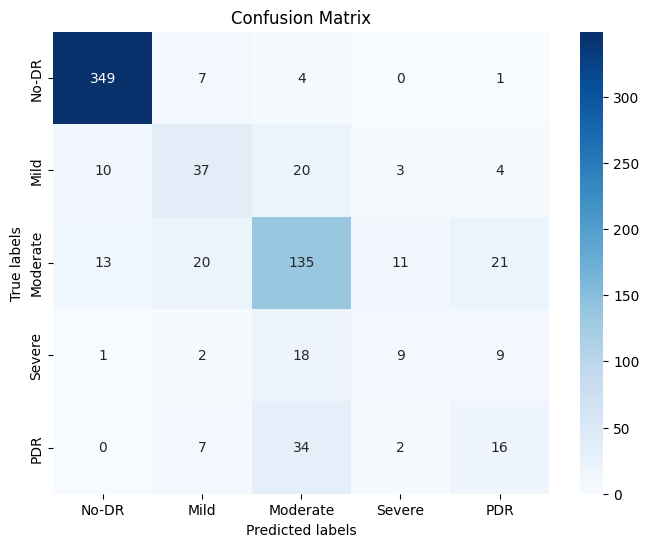

In [41]:

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conMat, annot=True, cmap='Blues', fmt='g', ax=ax)

# Add labels, title, and axis ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No-DR', 'Mild', 'Moderate', 'Severe', 'PDR'])
ax.yaxis.set_ticklabels(['No-DR', 'Mild', 'Moderate', 'Severe', 'PDR'])
plt.show()

Text(0.5, 1.0, 'Training Accuracy over 100 epochs')

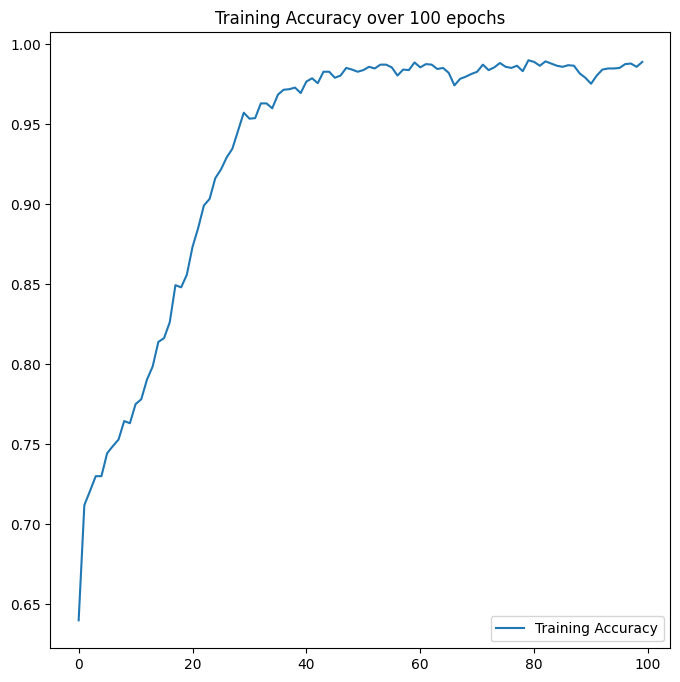

In [42]:
acc = hist.history['accuracy']
loss = hist.history['loss']

plt.figure(figsize = (8,8))
plt.subplot(1,1,1)
plt.plot(range(100),acc,label='Training Accuracy')
plt.legend(loc="lower right")
plt.title("Training Accuracy over 100 epochs")

Text(0.5, 1.0, 'Training Loss over 100 epochs')

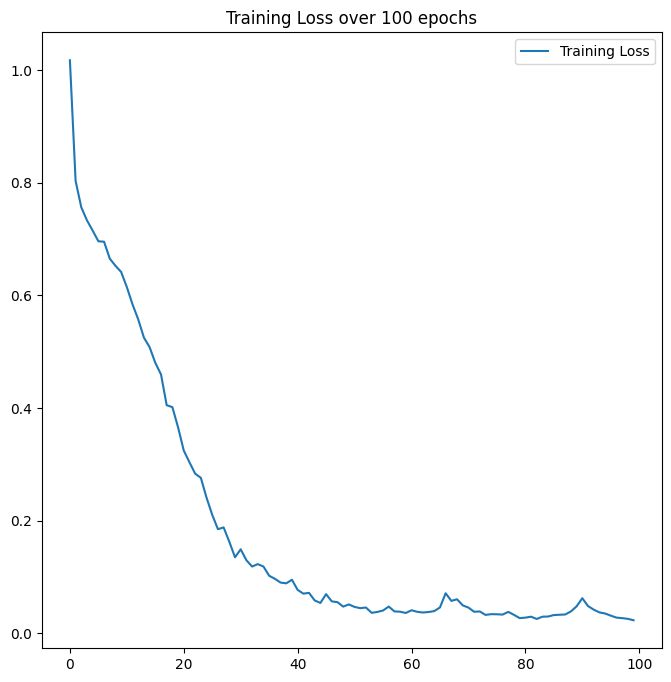

In [43]:
plt.figure(figsize = (8,8))
plt.subplot(1,1,1)
plt.plot(range(100),loss,label='Training Loss')
plt.legend(loc="upper right")
plt.title("Training Loss over 100 epochs")